In [1]:
#Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set(style='darkgrid')
from sklearn.model_selection import train_test_split
from PIL import Image
from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import random
from tqdm import tqdm
import splitfolders
import pathlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import cv2

C:\Users\aarya\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Reading data 

labels_df = pd.read_csv('Brain_Tumor_Dataset/metadata.csv')
df = pd.DataFrame(labels_df)
print(tabulate(df.head(), headers='keys', tablefmt='grid', showindex=False))

+--------------+-----------------+---------+----------+--------+---------------+
|   Unnamed: 0 | image           | class   | format   | mode   | shape         |
+==============+=================+=========+==========+========+===============+
|            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
+--------------+-----------------+---------+----------+--------+---------------+
|            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
+--------------+-----------------+---------+----------+--------+---------------+
|            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
+--------------+-----------------+---------+----------+--------+---------------+
|            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
+--------------+-----------------+---------+----------+--------+---------------+
|            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |
+--------------+------------

In [3]:
# Listing the files in the directory
os.listdir('Brain_Tumor_Dataset/Brain Tumor Dataset')

['Brain Tumor', 'Healthy']

In [4]:
# Shape of the data
df.shape

(4600, 6)

In [50]:
len_norm = len(df[df['class']=='normal'])
len_brain = len(df[df['class']=='tumor'])
ratio = (len_norm/len(df))*100
print("Number of normal brain images:", len_norm)
print("Number of brain tumor images:", len_brain)
print("Proportion of healthy to brain tumor images: ", round(ratio, 0),":",round(100-ratio, 0))

Number of normal brain images: 2087
Number of brain tumor images: 2513
Proportion of healthy to brain tumor images:  45.0 : 55.0


## Data Preparation


In [ ]:
# Splitting dataset to train_set, test_set

data_dir = 'Brain_Tumor_Dataset/Brain Tumor Dataset'
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='Brain_Tumor_Dataset/brain', seed=42, ratio=(0.8, 0.2))

# Step 2: Rename 'val' folder to 'test'
val_dir = os.path.join('Brain_Tumor_Dataset/brain', 'val')
test_dir = os.path.join('Brain_Tumor_Dataset/brain', 'test')

# Check if 'val' directory exists, then rename it
if os.path.exists(val_dir):
    os.rename(val_dir, test_dir)

In [52]:
# New dataset path
data_dir = 'Brain_Tumor_Dataset/brain/'
data_dir = pathlib.Path(data_dir)

#Preprocessing that will be applied on the dataset

transform_raw = transforms.Compose(
    {
        transforms.ToTensor()
    }
)

In [53]:
# Define an object of the custom dataset for the train, test and val.
train_set_raw = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform_raw) 
train_set_raw.transform
test_set_raw = torchvision.datasets.ImageFolder(data_dir.joinpath("test"), transform=transform_raw)
test_set_raw.transform
#val_set_raw = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform_raw)
#val_set_raw.transform

Compose(
    ToTensor()
)

In [54]:
print(train_set_raw)
print(test_set_raw)

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: Brain_Tumor_Dataset\brain\train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 921
    Root location: Brain_Tumor_Dataset\brain\test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


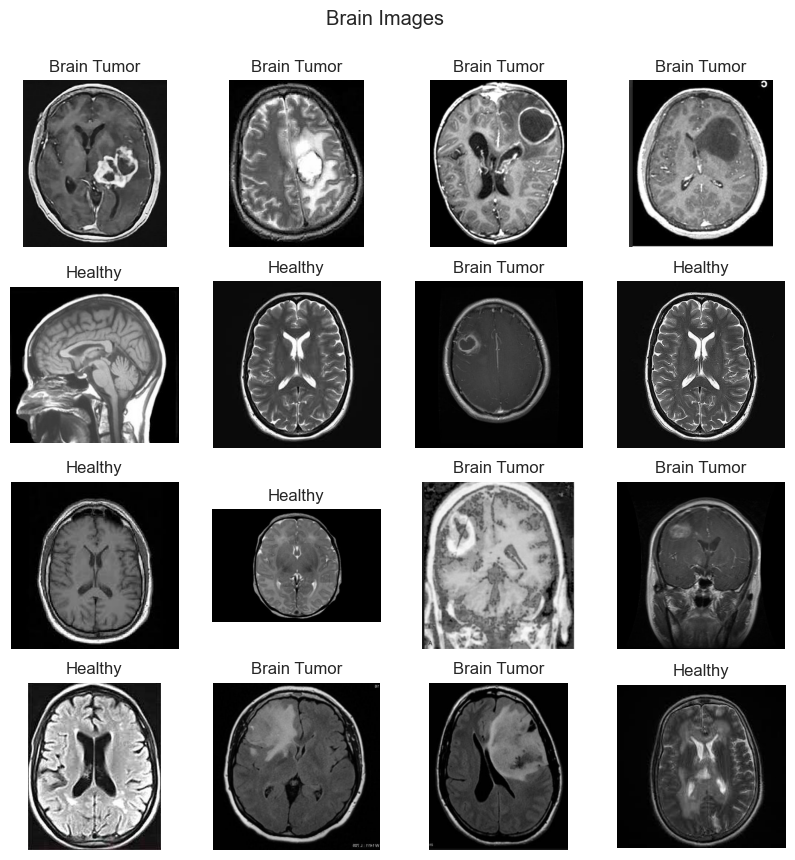

In [55]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4

idx = 0

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set_raw), size=(1,)).item() # Taking a random picture from the training set
    img, label = train_set_raw[sample_idx] # Retrieves Image and label
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label]) #Puts label if there is tumor or healthy
    plt.axis("off") #Removing the xis
    img_np = img.numpy().transpose((1, 2, 0)) # Converting tensor to numpy array which is necessary for matplotlib
    #Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1) #Images are typically represented in 0 to 255 range
    plt.imshow(img_valid_range) 
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [56]:
class AdaptiveThresholding:
    def __call__(self, img):
        # Convert PIL image to grayscale numpy array
        img_np = np.array(img.convert("L"))  # Convert to grayscale for thresholding
        # Apply adaptive thresholding using OpenCV
        thresholded = cv2.adaptiveThreshold(img_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        # Stack the grayscale thresholded image across RGB channels
        thresholded_rgb = np.stack([thresholded] * 3, axis=-1)
        # Convert back to PIL image in RGB format
        return Image.fromarray(thresholded_rgb, "RGB")

In [57]:
#Preprocessing that will be applied on the dataset

transform = transforms.Compose(
    [
        #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        #AdaptiveThresholding(), 
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.5], std=[0.5])
        #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) #Using these values is common Practice for Imagenet and torch
        #Normalising the data is what makes the image blue in colour
   ]
)

In [58]:
# Define an object of the custom dataset for the train, test and val.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
test_set = torchvision.datasets.ImageFolder(data_dir.joinpath("test"), transform=transform)
test_set.transform
#val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
#val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [59]:
sample_idx = torch.randint(len(train_set), size=(1,)).item() # Taking a random picture from the training set
img, label = train_set[sample_idx] # Retrieves Image and label

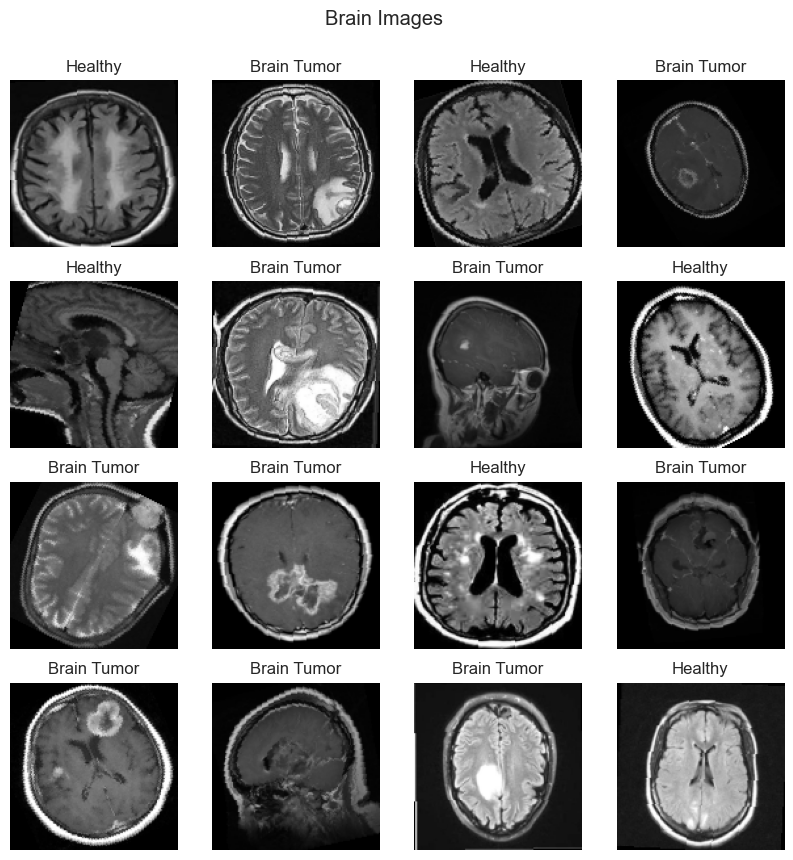

In [60]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item() # Taking a random picture from the training set
    img, label = train_set[sample_idx] # Retrieves Image and label
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label]) #Puts label if there is tumor or healthy
    plt.axis("off") #Removing the xis
    img_np = img.numpy().transpose((1, 2, 0)) # Converting tensor to numpy array which is necessary for matplotlib
    #Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1) #Images are typically represented in 0 to 255 range
    plt.imshow(img_valid_range) 
    plt.suptitle('Brain Images', y=0.95)
plt.show()

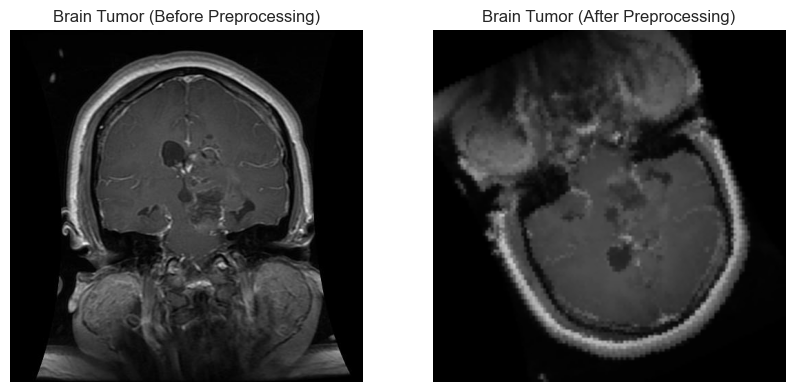

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Sample indices for the two images
sample_idx = random_int = random.randint(0, 3679)

# Retrieve images and labels
img1, label1 = train_set_raw[sample_idx]
img2, label2 = train_set[sample_idx]

# Convert tensors to numpy arrays and clip values for display
img1_np = np.clip(img1.numpy().transpose((1, 2, 0)), 0, 1)
img2_np = np.clip(img2.numpy().transpose((1, 2, 0)), 0, 1)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#fig.suptitle('Brain Images', y=0.95)

# Display first image
axes[0].imshow(img1_np)
axes[0].set_title(CLA_label[label1]+" (Before Preprocessing)")  # Set label as title
axes[0].axis("off")  # Hide axis

# Display second image
axes[1].imshow(img2_np)
axes[1].set_title(CLA_label[label2]+ " (After Preprocessing)")  # Set label as title
axes[1].axis("off")  # Hide axis

plt.show()


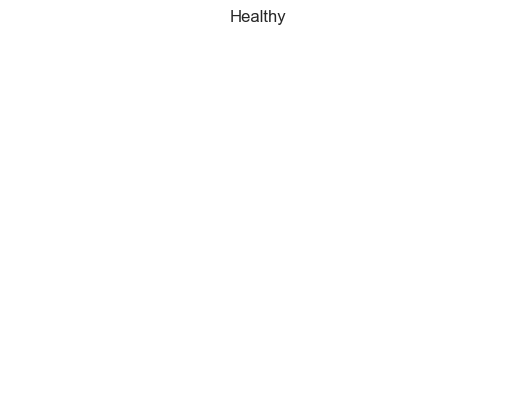

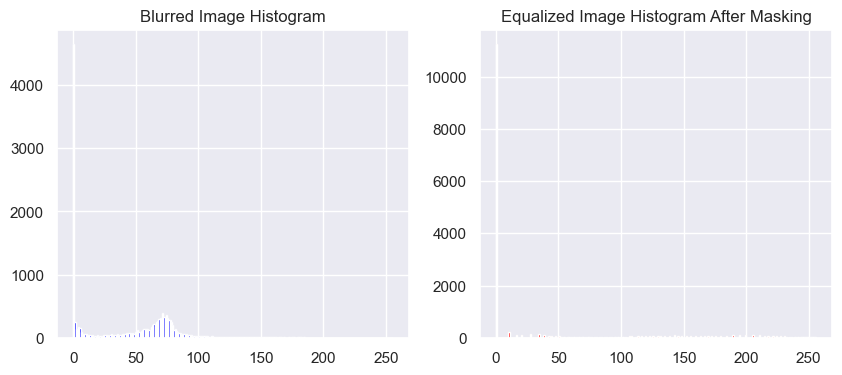

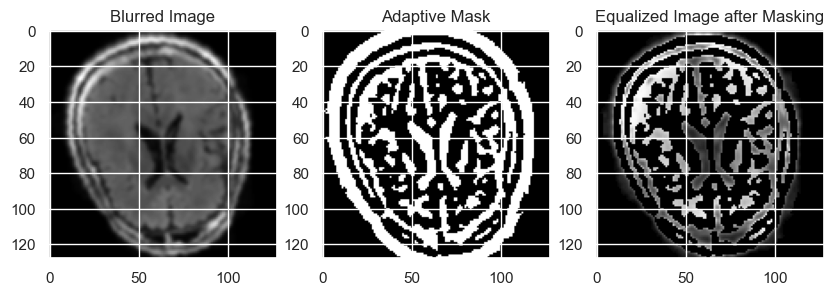

In [62]:
sample_idx = torch.randint(len(train_set), size=(1,)).item() # Taking a random picture from the training set
img, label = train_set[sample_idx] # Retrieves Image and label
plt.title(CLA_label[label]) #Puts label if there is tumor or healthy
plt.axis("off") #Removing the xis
img_np = img.numpy().transpose((1, 2, 0)) # Converting tensor to numpy array which is necessary for matplotlib
#Clip pixel values to [0, 1]
#img_valid_range = np.clip(img_np, 0, 1) #Images are typically represented in 0 to 255 range
img_valid_range = np.clip(img_np, 0, 1)
img_valid_range.shape
# Load your image (assuming it's already in (256, 256, 3) format)
# If the image is already loaded as 'img', skip this step
# img = cv2.imread('your_image_path') # Use if loading from file

# Convert the image to grayscale
gray_img = cv2.cvtColor(img_valid_range, cv2.COLOR_BGR2GRAY)

if gray_img.dtype != np.uint8:
    # Normalize to range 0-255
    gray_img = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)
    # Then convert to uint8
    gray_img = gray_img.astype(np.uint8)

# Step 1: Apply Gaussian blur
blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

# Step 2: Create an adaptive mask based on local pixel intensity
adaptive_mask = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                      cv2.THRESH_BINARY_INV, 11, 2)

# Step 3: Apply the mask to the blurred image
masked_img = cv2.bitwise_and(blurred_img, blurred_img, mask=adaptive_mask)

# Step 4: Apply histogram equalization to the masked image
equalized_img = cv2.equalizeHist(masked_img)

# Plot the results
plt.figure(figsize=(10, 4))

# Plot histogram of the blurred image
plt.subplot(1, 2, 1)
plt.hist(blurred_img.ravel(), bins=256, range=[0, 256], color='blue')
plt.title('Blurred Image Histogram')

# Plot histogram of the equalized image after applying the mask
plt.subplot(1, 2, 2)
plt.hist(equalized_img.ravel(), bins=256, range=[0, 256], color='red')
plt.title('Equalized Image Histogram After Masking')

# Show the images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(blurred_img, cmap='gray')
plt.title('Blurred Image')

plt.subplot(1, 3, 2)
plt.imshow(adaptive_mask, cmap='gray')
plt.title('Adaptive Mask')

plt.subplot(1, 3, 3)
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized Image after Masking')

plt.show()


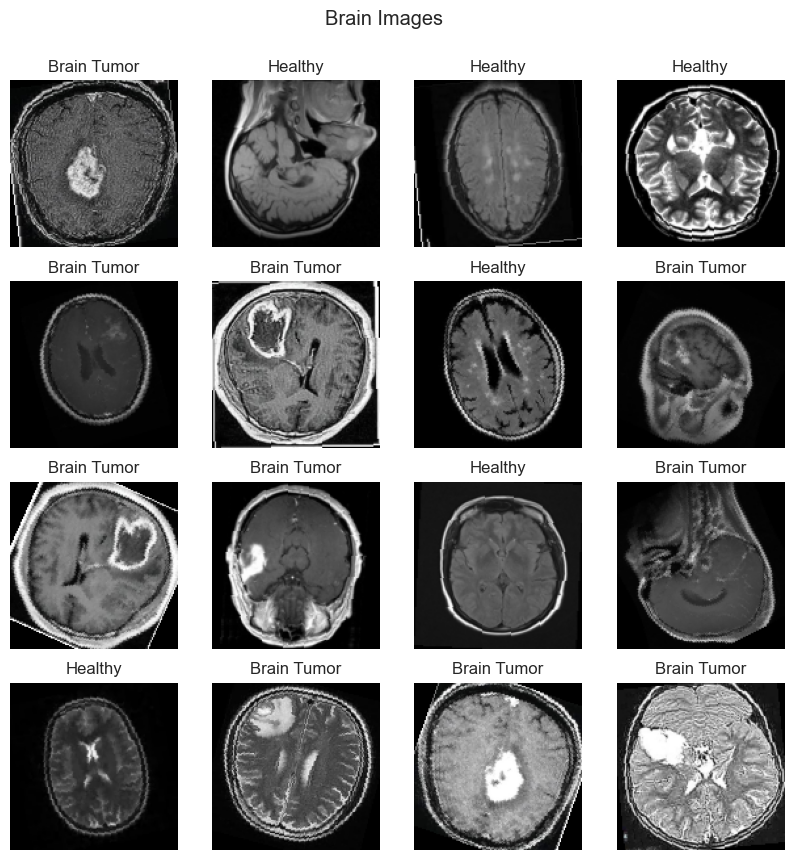

In [63]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item() # Taking a random picture from the training set
    img, label = train_set[sample_idx] # Retrieves Image and label
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label]) #Puts label if there is tumor or healthy
    plt.axis("off") #Removing the xis
    img_np = img.numpy().transpose((1, 2, 0)) # Converting tensor to numpy array which is necessary for matplotlib
    #Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1) #Images are typically represented in 0 to 255 range
    plt.imshow(img_valid_range) 
    plt.suptitle('Brain Images', y=0.95)
plt.show()

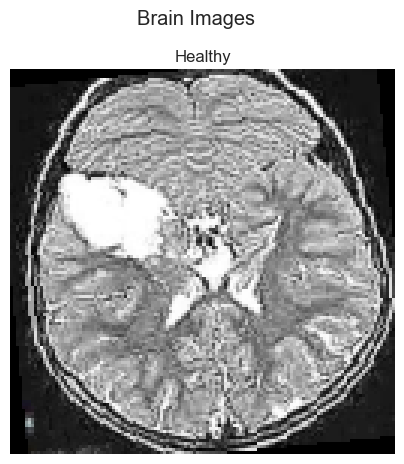

In [64]:
figure = plt.figure(figsize=(5, 5))
sample_idx = torch.randint(len(train_set), size=(1,)).item() # Taking a random picture from the training set
img, label = train_set[sample_idx] # Retrieves Image and label
plt.title(CLA_label[label]) #Puts label if there is tumor or healthy
plt.axis("off") #Removing the xis
img_np = img.numpy().transpose((1, 2, 0)) # Converting tensor to numpy array which is necessary for matplotlib
#Clip pixel values to [0, 1]
#img_valid_range = np.clip(img_np, 0, 1) #Images are typically represented in 0 to 255 range
plt.imshow(img_valid_range) 
plt.suptitle('Brain Images', y=1)
plt.show()

In [65]:
# Get the sizes
train_size = len(train_set)
#val_size = len(val_set)
test_size = len(test_set)

print(f"Training set size: {train_size} images")
#print(f"Validation set size: {val_size} images")
print(f"Test set size: {test_size} images")

Training set size: 3679 images
Test set size: 921 images


In [68]:
import os
import numpy as np
import cv2  # OpenCV for image processing
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Paths to the dataset
train_dir = 'Brain_Tumor_Dataset/brain/train'
#val_dir = 'Brain_Tumor_Dataset/brain/val'
test_dir = 'Brain_Tumor_Dataset/brain/test'

# Function to load images and labels
def load_images_and_labels(directory):
    images = []
    labels = []

    # Get total number of images for the progress bar
    total_images = sum(len(files) for _, _, files in os.walk(directory))
    
    # Use a single tqdm progress bar for all images
    with tqdm(total=total_images, desc=f"Loading images from {directory}") as pbar:
        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (128, 128))
                        #img = cv2.resize(img, (256, 256))  # Resize if needed
                        #img = cv2.resize(img, (128, 128))  # Resize if needed
                        images.append(img)
                        labels.append(label)
                    pbar.update(1)  # Update progress bar for each image loaded
    
    return np.array(images), np.array(labels)

# Load the datasets
X_train, y_train = load_images_and_labels(train_dir)
#X_val, y_val = load_images_and_labels(val_dir)
X_test, y_test = load_images_and_labels(test_dir)

Loading images from Brain_Tumor_Dataset/brain/train: 100%|████████████████████████| 3679/3679 [00:22<00:00, 162.10it/s]
Loading images from Brain_Tumor_Dataset/brain/test: 100%|███████████████████████████| 921/921 [00:06<00:00, 142.30it/s]


In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3679, 128, 128, 3)
(3679,)
(921, 128, 128, 3)
(921,)


In [70]:
import numpy as np

# Move the last sample from test to train
X_train = np.append(X_train, X_test[-1:,:,:,:], axis=0)
y_train = np.append(y_train, y_test[-1:], axis=0)

# Remove the last sample from test
X_test = X_test[:-1]
y_test = y_test[:-1]

print("New shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

New shapes:
X_train: (3680, 128, 128, 3)
y_train: (3680,)
X_test: (920, 128, 128, 3)
y_test: (920,)


# 4. Dimensionality Reduction 

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def BW(X_train):
    # Assuming X_train has the shape (3680, 256, 256, 3)
    X_train_grayscale = np.zeros((len(X_train), 128, 128))  # Initialize a 3D array for grayscale images

    for i, image_raw in enumerate(X_train):
        # Sum across the color channels to create a grayscale image
        image_sum = image_raw.sum(axis=2)
        # Normalize the image
        image_bw = image_sum / image_sum.max()
        # Store the grayscale image in the new array
        X_train_grayscale[i] = image_bw
    return X_train_grayscale

X_train = BW(X_train)
X_test = BW(X_test)

print("New shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

New shapes:
X_train: (3680, 128, 128)
y_train: (3680,)
X_test: (920, 128, 128)
y_test: (920,)


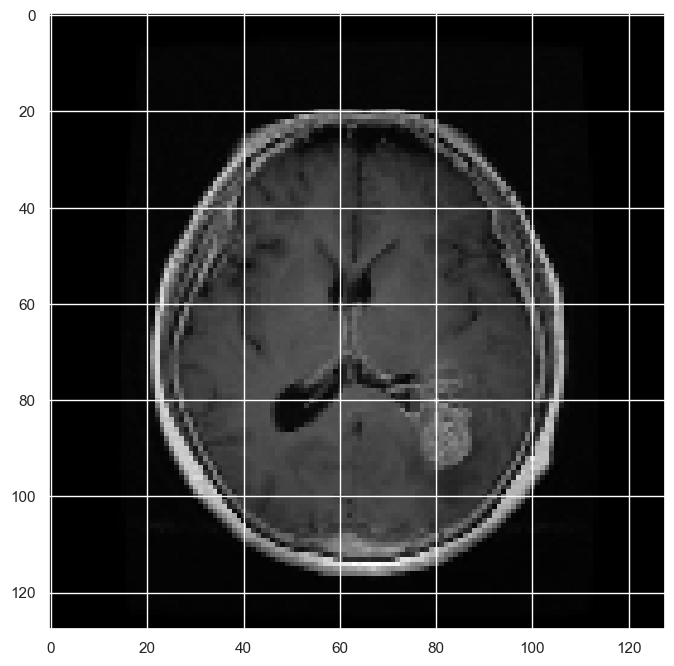

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_flat = X_train_flat.astype(np.float32)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_flat = X_test_flat.astype(np.float32)

#X_train_flat = scaler.fit_transform(X_train_flat)
#X_test_flat = scaler.fit_transform(X_test_flat)
X_test_flat.shape
plt.figure(figsize=[12,8])
plt.imshow(X_train[1], cmap=plt.cm.gray)

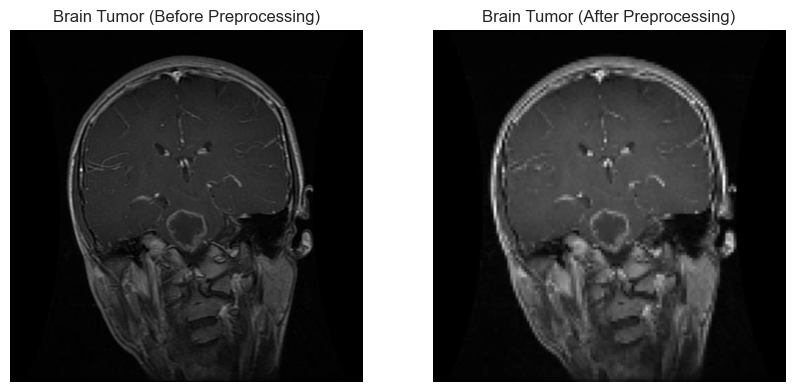

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Sample indices for the two images
sample_idx = random_int = random.randint(0, 3679)

# Retrieve images and labels
img1, label1 = train_set_raw[sample_idx]
#img2 = X_train[sample_idx]

# Convert tensors to numpy arrays and clip values for display
img1_np = np.clip(img1.numpy().transpose((1, 2, 0)), 0, 1)
#img2_np = np.clip(img2.numpy().transpose((1, 2, 0)), 0, 1)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#fig.suptitle('Brain Images', y=0.95)

# Display first image
axes[0].imshow(img1_np)
axes[0].set_title(CLA_label[label1]+" (Before Preprocessing)")  # Set label as title
axes[0].axis("off")  # Hide axis

# Display second image
axes[1].imshow(X_train[sample_idx], cmap=plt.cm.gray)
axes[1].set_title(CLA_label[label1]+ " (After Preprocessing)")  # Set label as title
axes[1].axis("off")  # Hide axis

plt.show()


### 4.1 PCA

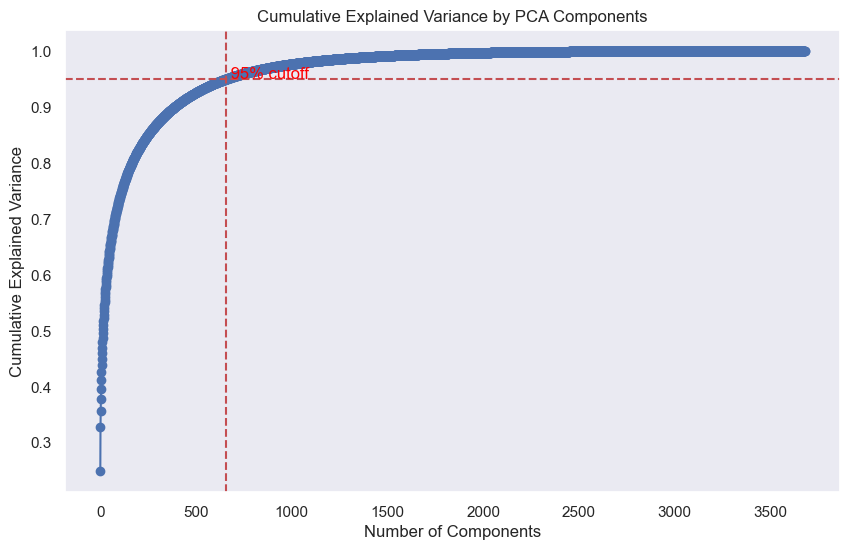

Number of components to achieve 90% variance: 388
Number of components to achieve 95% variance: 657
Number of components to achieve 99% variance: 1413


In [92]:
#With timer

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import concurrent.futures
import time

def fit_pca(X):
    pca = PCA()
    pca.fit(X)
    return pca

pca = None
timeout_seconds = 7200  # 60 minutes

try:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(fit_pca, X_train_flat)
        pca = future.result(timeout=timeout_seconds)
except concurrent.futures.TimeoutError:
    print("PCA fitting exceeded the time limit of 60 minutes and was terminated.")
    pca = None

# Proceed only if PCA was successful
if pca:
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.axhline(y=0.95, color='r', linestyle='--')  # Example for 95% variance
    plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='--')
    plt.text(np.argmax(cumulative_variance >= 0.95) + 1, 0.95, ' 95% cutoff', color='red')
    plt.show()

    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 because index starts at 0
    print(f'Number of components to achieve 90% variance: {n_components_90}')

    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f'Number of components to achieve 95% variance: {n_components_95}')

    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    print(f'Number of components to achieve 99% variance: {n_components_99}')
else:
    print("PCA process did not complete successfully.")


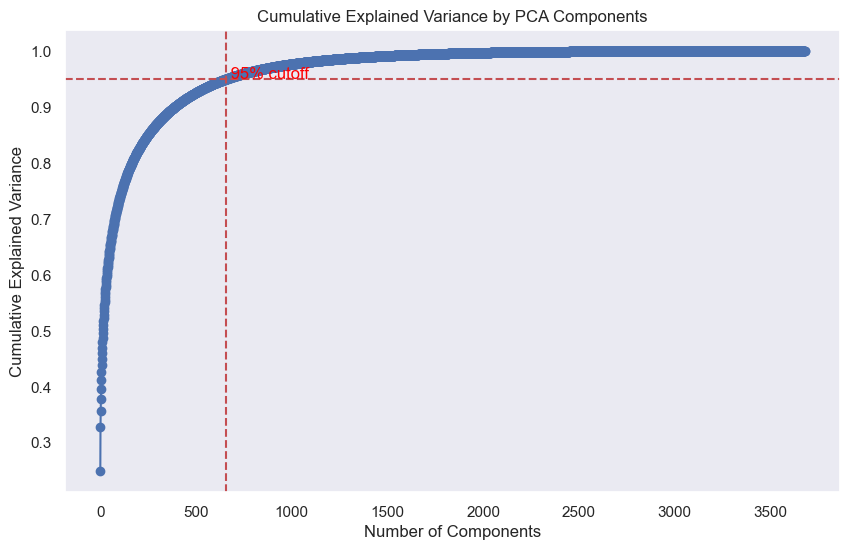

In [122]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # Example for 95% variance
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='--')
plt.text(np.argmax(cumulative_variance >= 0.95) + 1, 0.95, ' 95% cutoff', color='red')
#plt.show()

# Save the figure
plt.draw() 
plt.savefig('cumulative_explained_variance.png')  # Adjust path and settings if needed

In [73]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Step 3: Apply PCA
n_components = 1413 # You can choose the number of components
pca = PCA(n_components=n_components)

# Fit and transform the data with a progress bar
pca = pca.fit(X_train_flat)
X_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Now, X_pca contains the PCA-transformed data
print("Original shape:", X_train_flat.shape)
print("PCA shape:", X_pca.shape)

Original shape: (3680, 16384)
PCA shape: (3680, 1413)


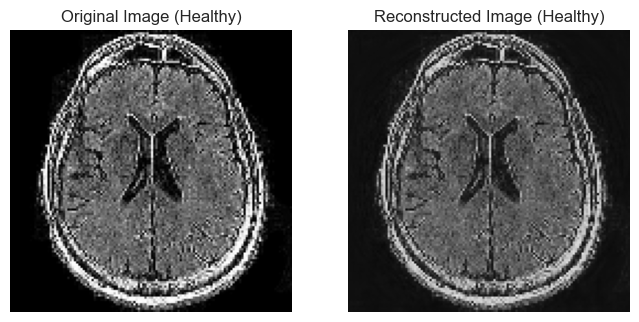

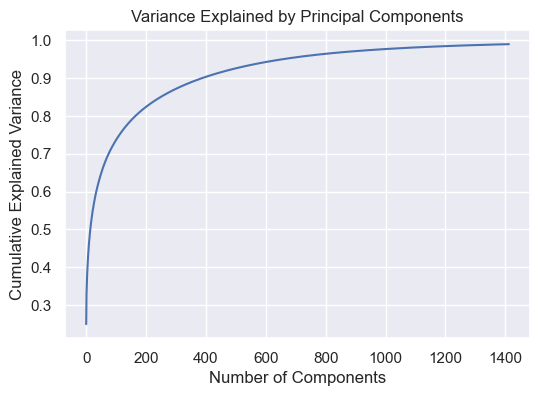

In [74]:
import numpy as np
import matplotlib.pyplot as plt

CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
# Inverse transform to reconstruct the images from the PCA components
X_reconstructed = pca.inverse_transform(X_pca) 

# Reshaping reconstructed images back to original shape (e.g., 256x256x3)
#X_reconstructed_images = X_reconstructed.reshape(-1,128, 128, 3)
X_reconstructed_images = X_reconstructed.reshape(-1,128,128, 1)  # Adjust to your image dimensions
#X_reconstructed_images = X_reconstructed.reshape(-1, 200, 200, 3)  # Adjust to your image dimensions

# Plotting the original vs. reconstructed image for a sample
sample_idx = torch.randint(len(train_set), size=(1,)).item()  # Choose an index to visualize
original_image = X_train[sample_idx]
reconstructed_image = X_reconstructed_images[sample_idx]
img, label = train_set[sample_idx] # Retrieves Image and label

plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap=plt.cm.gray)
plt.title("Original Image ("+ CLA_label[label] + ")")
plt.axis('off')

# Reconstructaed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.title("Reconstructed Image ("+ CLA_label[label] + ")")
plt.axis('off')

plt.show()

# Cumulative variance explained by PCA components
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.show()

### 4.2 LDA

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
import numpy as np

X_train_flat
X_test_flat

lda = LDA(n_components=1) # n_components is 1, because there are two classes: "brain tumor" and "healthy", formula is n(classes)-1

#Training the lDA model
lda.fit(X_train_flat, y_train)

# Transform the features to the new LDA space
X_lda = lda.transform(X_train_flat)
X_test_lda = lda.transform(X_test_flat)

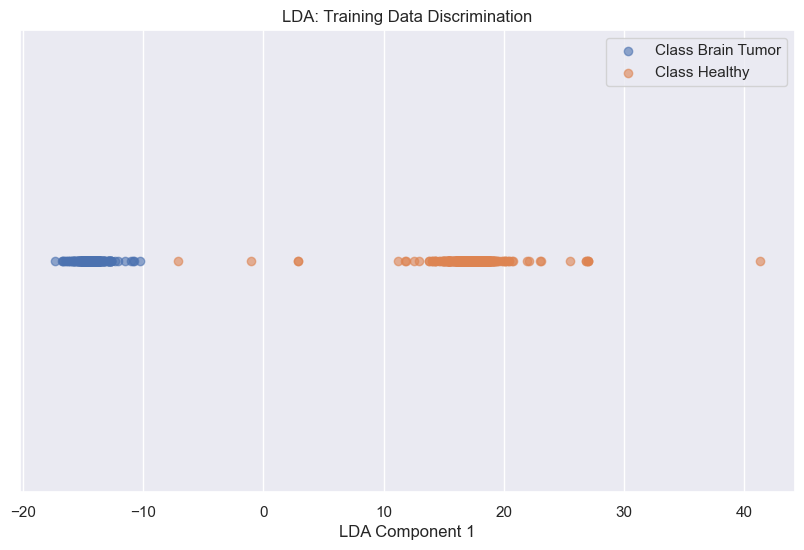

In [77]:
import matplotlib.pyplot as plt

# Assuming the transformed data `X_train_lda` is one-dimensional, as n_components=1
def plot_lda_results(X_lda, y_train):
    plt.figure(figsize=(10, 6))

    # Scatter plot for each class
    for label in np.unique(y_train):
        plt.scatter(
            X_lda[y_train == label],
            np.zeros_like(X_lda[y_train == label]),
            
            label=f"Class {label}",
            alpha=0.6,
        )

    plt.xlabel("LDA Component 1")
    plt.yticks([])  # Hide y-axis since it's unnecessary in 1D plot
    plt.legend()
    plt.title("LDA: Training Data Discrimination")
    plt.show()

# Call the plotting function
plot_lda_results(X_lda, y_train)


Error during inverse transformation: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1413 is different from 300)


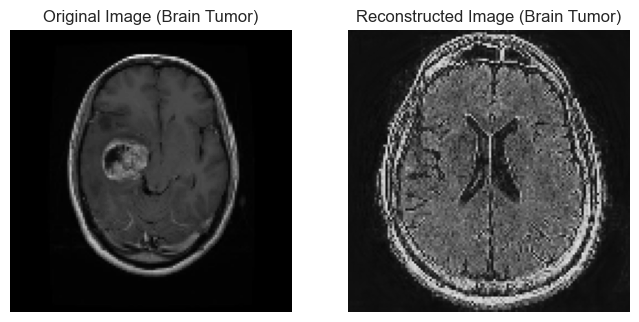

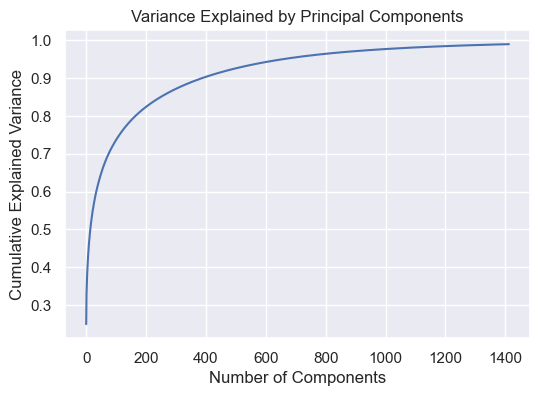

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Label dictionary
CLA_label = {
    0: 'Brain Tumor',
    1: 'Healthy'
}

# Number of PCA components originally used (assumed known)
n_pca_components = 300  # Adjust this to the actual number of components used in PCA

# Expand `X_lda` back to match `n_pca_components`
# Here, we replicate each LDA component across all PCA components (naive approach)
X_lda_expanded = np.repeat(X_lda, n_pca_components, axis=1)

# Inverse transform to reconstruct the images from PCA components
try:
    X_reconstructed = pca.inverse_transform(X_lda_expanded)
except ValueError as e:
    print(f"Error during inverse transformation: {e}")

# Reshape to original image dimensions, e.g., 256x256x3
X_reconstructed_images = X_reconstructed.reshape(-1, 128, 128, 1)

# Visualization
sample_idx = torch.randint(len(X_train), size=(1,)).item()
original_image = X_train[sample_idx]
img, label = train_set[sample_idx]  # Retrieves image and label

# Plot original and reconstructed images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap=plt.cm.gray)
plt.title("Original Image ("+ CLA_label[label] + ")")
plt.axis('off')

# Reconstructaed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.title("Reconstructed Image ("+ CLA_label[label] + ")")
plt.axis('off')

plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.show()


### 4.3 PCA and LDA

In [79]:
try:
    # Apply LDA to training data
    lda = LDA(n_components=1)  # n_components is 1, because there are two classes: "brain tumor" and "healthy", formula is n(classes)-1
    X_pca_lda = lda.fit_transform(X_pca, y_train)

    # Transform test and validation sets using the LDA model
    X_test_pca_lda = lda.transform(X_test_pca)

    # Check the shapes after LDA
    print("Training set after LDA:", X_pca_lda.shape)
    print("Test set after LDA:", X_test_pca_lda.shape)

except MemoryError:
    print("MemoryError: Not enough memory to perform LDA. Please consider reducing the dataset size or using a machine with more memory.")


Training set after LDA: (3680, 1)
Test set after LDA: (920, 1)


### 4.4 Autoencoders

In [80]:
# Autoencoders
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import BinaryCrossentropy
import pandas as pd

# Define the input shape for grayscale image data
input_shape = (128, 128, 1)

# Encoder Layers
input_img = Input(shape=input_shape)

# Encoding Layers (Convolutional)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

# Decoder Layers (Convolutional)
decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)

# Output layer to reconstruct the grayscale input image shape with sigmoid activation
output_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

# Combine Encoder and Decoder layers into the autoencoder model
autoencoder = Model(inputs=input_img, outputs=output_img)

# Compile the model
autoencoder.compile(optimizer=Adadelta(), loss=BinaryCrossentropy())

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# For dimensionality reduction, create an encoder model that outputs the encoded layer only
encoder = Model(inputs=input_img, outputs=encoded)

# Obtain reduced dimension features for training and testing sets
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

# Flatten and convert encoded features to a DataFrame for compatibility with further processing
encoded_train_flat = pd.DataFrame(encoded_train.reshape(encoded_train.shape[0], -1))
encoded_train_flat = encoded_train_flat.add_prefix('feature_')

encoded_test_flat = pd.DataFrame(encoded_test.reshape(encoded_test.shape[0], -1))
encoded_test_flat = encoded_test_flat.add_prefix('feature_')

# Display the dimensionality-reduced training data
encoded_train_flat.head()


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.6928 - val_loss: 0.6925
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - loss: 0.6919 - val_loss: 0.6915
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 0.6913 - val_loss: 0.6908
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.6906 - val_loss: 0.6900
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,0.000000,0.002893,0.004112,0.000000,0.002526,0.000000,0.0,0.003031,0.001962,0.030208,...,0.007736,0.001162,0.000555,0.002455,0.002185,0.000000,0.000719,0.0,0.000269,0.002480
1,0.000000,0.003133,0.005167,0.000000,0.003239,0.000000,0.0,0.002943,0.001047,0.005540,...,0.019521,0.000000,0.001916,0.005941,0.001601,0.000266,0.000283,0.0,0.000901,0.001663
2,0.004199,0.040524,0.056319,0.003329,0.032698,0.008708,0.0,0.013683,0.024242,0.057909,...,0.029474,0.000000,0.031295,0.011527,0.000000,0.000000,0.000000,0.0,0.039290,0.003372
3,0.001042,0.003210,0.003557,0.000057,0.003495,0.000000,0.0,0.002199,0.002188,0.007880,...,0.009198,0.000000,0.001112,0.001986,0.003361,0.000000,0.000606,0.0,0.000696,0.000930
4,0.001138,0.017650,0.044768,0.003181,0.036061,0.015290,0.0,0.011597,0.017353,0.086448,...,0.038475,0.000000,0.022238,0.005904,0.001780,0.000000,0.000000,0.0,0.018353,0.000842


# 5. Classification

### 5.1 Prior to Dimensionality Reduction

In [86]:
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Define a dictionary of classifiers with their corresponding names
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Linear SVC": LinearSVC(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5)
}

# Initialize a dictionary to hold the classification report metrics for each classifier
reports = {}

# Loop through each classifier, train it, predict, and store classification report
for name, clf in classifiers.items():
    # Train the classifier on the PCA-transformed training data
    clf.fit(X_train_flat, y_train)
    
    # Predict on PCA-transformed test set
    y_test_pred = clf.predict(X_test_flat)
    
    # Generate the classification report
    report = classification_report(y_test, y_test_pred, output_dict=True, digits=4)
    
    # Save the report in the dictionary with the classifier name as the key
    reports[name] = report

# Optionally, convert the dictionary to a pandas DataFrame for easier visualization
df_reports = pd.DataFrame(reports).T  # Transpose for better readability
print(df_reports)

C:\Users\aarya\anaconda3\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                                                     Brain Tumor  \
Logistic Regression            {'precision': 0.9464285714285714, 'recall': 0....   
Linear SVC                     {'precision': 0.9478957915831663, 'recall': 0....   
Ridge Classifier               {'precision': 0.951417004048583, 'recall': 0.9...   
Passive Aggressive Classifier  {'precision': 0.9481037924151696, 'recall': 0....   
SGD Classifier                 {'precision': 0.9396378269617707, 'recall': 0....   
K-Nearest Neighbors (K=5)      {'precision': 0.9240246406570842, 'recall': 0....   

                                                                         Healthy  \
Logistic Regression            {'precision': 0.9375, 'recall': 0.935251798561...   
Linear SVC                     {'precision': 0.9287410926365796, 'recall': 0....   
Ridge Classifier               {'precision': 0.9225352112676056, 'recall': 0....   
Passive Aggressive Classifier  {'precision': 0.9331742243436754, 'recall': 

### 5.2 After PCA

In [87]:
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Define a dictionary of classifiers with their corresponding names
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Linear SVC": LinearSVC(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5)
}

# Function for Mahalanobis classifier (if you plan to include it in your classifiers)
def mahalanobis_classifier(X_train, y_train, X_test):
    """Classify using Mahalanobis distance."""
    inv_covmat = np.linalg.inv(np.cov(X_train, rowvar=False))
    distances = []
    for x in X_test:
        dists = np.array([mahalanobis(x, x_train, inv_covmat) for x_train in X_train])
        distances.append(dists)
    distances = np.array(distances)
    nearest_indices = np.argmin(distances, axis=1)
    return y_train[nearest_indices]

# Initialize a dictionary to hold the classification report metrics for each classifier
reports = {}

# Loop through each classifier, train it, predict, and store classification report
for name, clf in classifiers.items():
    # Train the classifier on the PCA-transformed training data
    clf.fit(X_pca, y_train)
    
    # Predict on PCA-transformed test set
    if name == "Mahalanobis Classifier":
        y_test_pred = mahalanobis_classifier(X_pca, y_train, X_test_pca)
    else:
        y_test_pred = clf.predict(X_test_pca)
    
    # Generate the classification report
    report = classification_report(y_test, y_test_pred, output_dict=True, digits=4)
    
    # Save the report in the dictionary with the classifier name as the key
    reports[name] = report

# Optionally, convert the dictionary to a pandas DataFrame for easier visualization
df_reports_pca = pd.DataFrame(reports).T  # Transpose for better readability
print(df_reports_pca)


                                                                     Brain Tumor  \
Logistic Regression            {'precision': 0.9536290322580645, 'recall': 0....   
Linear SVC                     {'precision': 0.9535353535353536, 'recall': 0....   
Ridge Classifier               {'precision': 0.9512195121951219, 'recall': 0....   
Passive Aggressive Classifier  {'precision': 0.9574036511156186, 'recall': 0....   
SGD Classifier                 {'precision': 0.9453441295546559, 'recall': 0....   
K-Nearest Neighbors (K=5)      {'precision': 0.9191919191919192, 'recall': 0....   

                                                                         Healthy  \
Logistic Regression            {'precision': 0.9292452830188679, 'recall': 0....   
Linear SVC                     {'precision': 0.9270588235294117, 'recall': 0....   
Ridge Classifier               {'precision': 0.9182242990654206, 'recall': 0....   
Passive Aggressive Classifier  {'precision': 0.927400468384075, 'recall': 0

### 4.3 After LDA

In [81]:
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Define a dictionary of classifiers with their corresponding names
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Linear SVC": LinearSVC(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5)
}

# Function for Mahalanobis classifier (if you plan to include it in your classifiers)
def mahalanobis_classifier(X_train, y_train, X_test):
    """Classify using Mahalanobis distance."""
    inv_covmat = np.linalg.inv(np.cov(X_train, rowvar=False))
    distances = []
    for x in X_test:
        dists = np.array([mahalanobis(x, x_train, inv_covmat) for x_train in X_train])
        distances.append(dists)
    distances = np.array(distances)
    nearest_indices = np.argmin(distances, axis=1)
    return y_train[nearest_indices]

# Initialize a dictionary to hold the classification report metrics for each classifier
reports = {}

# Loop through each classifier, train it, predict, and store classification report
for name, clf in classifiers.items():
    # Train the classifier on the PCA-transformed training data
    clf.fit(X_lda, y_train)
    
    # Predict on PCA-transformed test set
    if name == "Mahalanobis Classifier":
        y_test_pred = mahalanobis_classifier(X_lda, y_train, X_test_lda)
    else:
        y_test_pred = clf.predict(X_test_lda)
    
    # Generate the classification report
    report = classification_report(y_test, y_test_pred, output_dict=True, digits=4)
    
    # Save the report in the dictionary with the classifier name as the key
    reports[name] = report

# Optionally, convert the dictionary to a pandas DataFrame for easier visualization
df_reports_lda = pd.DataFrame(reports).T  # Transpose for better readability
#print(df_reports_lda)


### 4.4 After PCA and LDA

In [82]:
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Define a dictionary of classifiers with their corresponding names
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Linear SVC": LinearSVC(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5)
}

# Function for Mahalanobis classifier (if you plan to include it in your classifiers)
def mahalanobis_classifier(X_train, y_train, X_test):
    """Classify using Mahalanobis distance."""
    inv_covmat = np.linalg.inv(np.cov(X_train, rowvar=False))
    distances = []
    for x in X_test:
        dists = np.array([mahalanobis(x, x_train, inv_covmat) for x_train in X_train])
        distances.append(dists)
    distances = np.array(distances)
    nearest_indices = np.argmin(distances, axis=1)
    return y_train[nearest_indices]

# Initialize a dictionary to hold the classification report metrics for each classifier
reports = {}

# Loop through each classifier, train it, predict, and store classification report
for name, clf in classifiers.items():
    # Train the classifier on the PCA-transformed training data
    clf.fit(X_pca_lda, y_train)
    
    # Predict on PCA-transformed test set
    if name == "Mahalanobis Classifier":
        y_test_pred = mahalanobis_classifier(X_pca_lda, y_train, X_test_pca_lda)
    else:
        y_test_pred = clf.predict(X_test_pca_lda)
    
    # Generate the classification report
    report = classification_report(y_test, y_test_pred, output_dict=True, digits=4)
    
    # Save the report in the dictionary with the classifier name as the key
    reports[name] = report

# Optionally, convert the dictionary to a pandas DataFrame for easier visualization
df_reports_pca_lda = pd.DataFrame(reports).T  # Transpose for better readability
#print(df_reports_pca_lda)


### 4.5 After Autoencoder

In [83]:
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Define a dictionary of classifiers with their corresponding names
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    "Linear SVC": LinearSVC(max_iter=5000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
    "K-Nearest Neighbors (K=5)": KNeighborsClassifier(n_neighbors=5)
}

# Function for Mahalanobis classifier (if you plan to include it in your classifiers)
def mahalanobis_classifier(X_train, y_train, X_test):
    """Classify using Mahalanobis distance."""
    inv_covmat = np.linalg.inv(np.cov(X_train, rowvar=False))
    distances = []
    for x in X_test:
        dists = np.array([mahalanobis(x, x_train, inv_covmat) for x_train in X_train])
        distances.append(dists)
    distances = np.array(distances)
    nearest_indices = np.argmin(distances, axis=1)
    return y_train[nearest_indices]

# Initialize a dictionary to hold the classification report metrics for each classifier
reports = {}

# Loop through each classifier, train it, predict, and store classification report
for name, clf in classifiers.items():
    # Train the classifier on the PCA-transformed training data
    clf.fit(encoded_train_flat, y_train)
    
    # Predict on PCA-transformed test set
    if name == "Mahalanobis Classifier":
        y_test_pred = mahalanobis_classifier(encoded_train_flat, y_train, encoded_test_flat)
    else:
        y_test_pred = clf.predict(encoded_test_flat)
    
    # Generate the classification report
    report = classification_report(y_test, y_test_pred, output_dict=True, digits=4)
    
    # Save the report in the dictionary with the classifier name as the key
    reports[name] = report

# Optionally, convert the dictionary to a pandas DataFrame for easier visualization
df_reports_autoencoder = pd.DataFrame(reports).T  # Transpose for better readability
#print(df_reports_autoencoder)


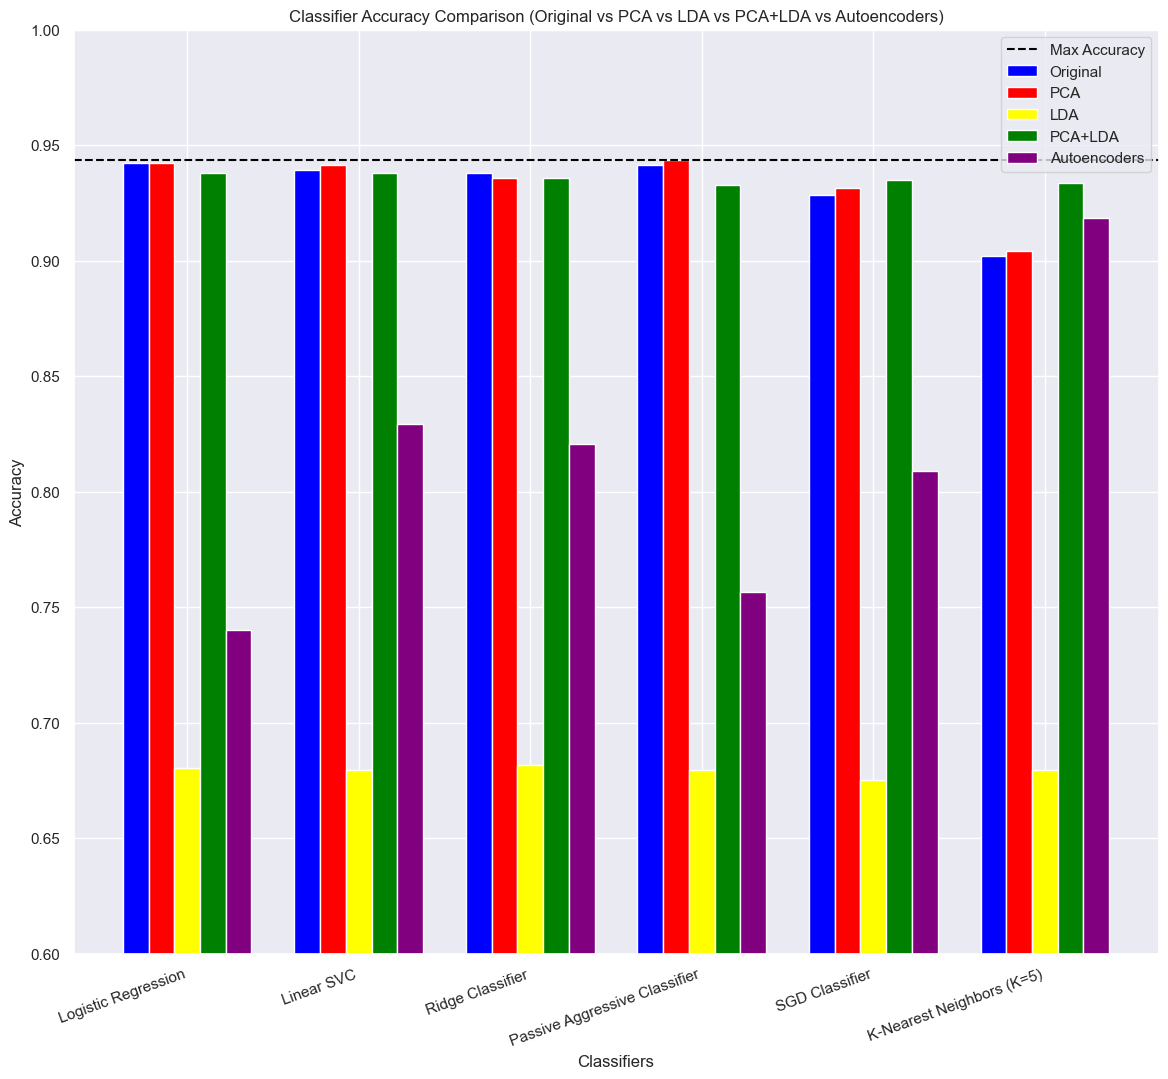

In [298]:
import matplotlib.pyplot as plt
import numpy as np

#Example data: replace with your actual data frames
accuracies = [df_reports.loc[clf, 'accuracy'] for clf in df_reports.index]
accuracies_pca = [df_reports_pca.loc[clf, 'accuracy'] for clf in df_reports_pca.index]
accuracies_lda = [df_reports_lda.loc[clf, 'accuracy'] for clf in df_reports_lda.index]
accuracies_pca_lda = [df_reports_pca_lda.loc[clf, 'accuracy'] for clf in df_reports_pca_lda.index]
accuracies_autoencoder = [df_reports_autoencoder.loc[clf, 'accuracy'] for clf in df_reports_autoencoder.index]

classifiers = df_reports.index  
x = np.arange(len(classifiers))  
bar_width = 0.15  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 12))

#Set bar positions to ensure they don’t overlap
bars1 = ax.bar(x - 2 * bar_width, accuracies, bar_width, label='Original', color='blue')
bars2 = ax.bar(x - bar_width, accuracies_pca, bar_width, label='PCA', color='red')
bars3 = ax.bar(x, accuracies_lda, bar_width, label='LDA', color='yellow')
bars4 = ax.bar(x + bar_width, accuracies_pca_lda, bar_width, label='PCA+LDA', color='green')
bars5 = ax.bar(x + 2 * bar_width, accuracies_autoencoder, bar_width, label='Autoencoders', color='purple')

#Calculate the maximum accuracy for the line
max_accuracy = max(max(accuracies), max(accuracies_pca), max(accuracies_lda),
                   max(accuracies_pca_lda), max(accuracies_autoencoder))

#Adding line for maximum accuracy
ax.axhline(max_accuracy, color='black', linestyle='--', label='Max Accuracy')

ax.set_xlabel('Classifiers')
ax.set_ylim(0.6, 1.0)  
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy Comparison (Original vs PCA vs LDA vs PCA+LDA vs Autoencoders)')
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=20, ha='right')
ax.legend()

plt.savefig('Classification.png')

# Display the bar chart
#plt.tight_layout()
plt.show()


In [305]:
import pandas as pd

# List of classifier names (or indices) in your reports
classifiers = df_reports.index.tolist()  # Assuming the classifiers are the index of your reports

# List of accuracy values for each source (these are already extracted as per your example)
accuracies = [df_reports.loc[clf, 'accuracy'] for clf in classifiers]
accuracies_pca = [df_reports_pca.loc[clf, 'accuracy'] for clf in classifiers]
accuracies_lda = [df_reports_lda.loc[clf, 'accuracy'] for clf in classifiers]
accuracies_pca_lda = [df_reports_pca_lda.loc[clf, 'accuracy'] for clf in classifiers]
accuracies_autoencoder = [df_reports_autoencoder.loc[clf, 'accuracy'] for clf in classifiers]

# Create a DataFrame to combine the accuracies
df_accuracy = pd.DataFrame({
    'Classifier': classifiers,
    'Baseline': accuracies,
    'PCA': accuracies_pca,
    'LDA': accuracies_lda,
    'PCA + LDA': accuracies_pca_lda,
    'Autoencoder': accuracies_autoencoder
})

# Reset index to remove the default numeric index (1, 2, 3, etc.)
df_accuracy.reset_index(drop=True, inplace=True)

# Style the dataframe for better readability, including the specific cell change
styled_df = df_accuracy.style.format({
    'Baseline': '{:.4f}',
    'PCA': '{:.4f}',
    'LDA': '{:.4f}',
    'PCA + LDA': '{:.4f}',
    'Autoencoder': '{:.4f}'
}).set_caption("Classifier Accuracy Comparison") \
  .set_table_styles([
      {'selector': 'th', 'props': [('background-color', '#70cfee'), ('color', 'black'), ('border', '1.5pt solid black'), 
                                   ('text-align', 'center'), ('padding', '10px')]},  # Header background color
      {'selector': 'td', 'props': [('background-color', '#F8FFFF'), ('border', '1.5pt solid black'), ('text-align', 'center'), 
                                   ('padding', '10px')]},  # Data cell background color
      {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},  # Caption styling
      {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center'), ('color', 'black')]},  # Caption text color
      {'selector': 'td:nth-child(2)', 'props': [('background-color', '#70cfee'), ('color', 'black'), ('text-align', 'center'), 
                                                ('padding', '10px'), ('border', '1.5pt solid black')]},  # Second column styling
      # Add styling for the specific 'PCA' cell in row 3 (index 2)
      
      {'selector': f'td:nth-child({df_accuracy.columns.get_loc("Baseline") + 2})',
       'props': [('background-color', '#c7c7c7' ), ('color', 'black')]}, 
    {'selector': f'tr:nth-child(4) td:nth-child({df_accuracy.columns.get_loc("LDA") + 1})',
       'props': [('background-color', '#00ff32' ), ('color', 'black')]},  
    {'selector': f'tr:nth-child(1) td:nth-child({df_accuracy.columns.get_loc("LDA") + 1})',
       'props': [('background-color', '#a3ffb5' ), ('color', 'black')]},  
    {'selector': f'tr:nth-child(2) td:nth-child({df_accuracy.columns.get_loc("LDA") + 1})',
       'props': [('background-color', '#a3ffb5' ), ('color', 'black')]},  
    {'selector': f'tr:nth-child(3) td:nth-child({df_accuracy.columns.get_loc("PCA") + 1})',
       'props': [('background-color', '#a3ffb5' ), ('color', 'black')]}, 
    {'selector': f'tr:nth-child(5) td:nth-child({df_accuracy.columns.get_loc("Autoencoder") + 1})',
       'props': [('background-color', '#a3ffb5' ), ('color', 'black')]},  
    {'selector': f'tr:nth-child(6) td:nth-child({df_accuracy.columns.get_loc("Autoencoder") + 1})',
       'props': [('background-color', '#a3ffb5' ), ('color', 'black')]},  
  ])  # Apply all styles to the dataframe

# Display the styled dataframe
styled_df


,Classifier,Baseline,PCA,LDA,PCA + LDA,Autoencoder
0,Logistic Regression,0.9424,0.9424,0.6804,0.9380,0.7402
1,Linear SVC,0.9391,0.9413,0.6793,0.9380,0.8293
2,Ridge Classifier,0.9380,0.9359,0.6815,0.9359,0.8207
3,Passive Aggressive Classifier,0.9413,0.9435,0.6793,0.9326,0.7565
4,SGD Classifier,0.9283,0.9315,0.6750,0.9348,0.8087
5,K-Nearest Neighbors (K=5),0.9022,0.9043,0.6793,0.9337,0.9185
